参考资料：https://blog.csdn.net/u013733326/article/details/80890454

# 一步步搭建循环神经网络

在这个章节中，你将使用numpy实现一个循环神经网络

循环神经网络（RNN）对于自然语言处理和其他序列任务非常有效，因为它们具有“记忆”功能。 它们可以一次读取一个输入$x^{<t>}$（如单词），并且通过隐藏层激活从一个时间步传递到下一个时间步来记住一些信息/上下文，这允许单向RNN从过去获取信息来处理后面的输入，双向RNN可以从过去和未来中获取上下文

有些东西需要声明：
- 上标[l]表示第l层
    - 举例：$a^{[4]}$表示第4层的激活值，$W^{[5]}与b^{[5]}$是第5层的参数
- 上标(i)表示第i个样本
    - 举例：$x^{(i)}$表示第i个输入的样本
- 上标<t>表示第t个时间步
    - 举例：$x^{<t>}$表示输入x的第t个时间步，$x^{(i)<t>}$表示输入x的第i个样本的第t个时间步
- 下标i表示向量的第i项
    - 举例：$a_i^{[l]}$表示l层中的第i个项的激活值
    
让我们先加载所需要的库

In [1]:
import numpy as np
import rnn_utils

## 1 - 循环神经网络的前向传播

我们来看一下下面的循环神经网络的图，在这里使用的是$T_x = T_y$，我们来实现它
![](images/RNN.png)
<center>图1：基本的RNN模型</center>

我们怎么才能实现它呢?有以下几个步骤：
1. 实现RNN的一个时间步所需要计算的东西
2. 在$T_x$时间步上实现一个循环，以便一次处理所有的输入

### 1.1 - RNN单元

循环神经网络可以看作是单元的重复，首先要实现单个时间步的计算，下图描述了RNN单元的单个时间步的操作
![](images/rnn_step_forward.png)
<center>图2：基本的RNN单元. 输入 $x^{\langle t \rangle}$ (当前输入) 与 $a^{\langle t - 1\rangle}$ (包含过去信息的上一隐藏层的激活值), 输出 $a^{\langle t \rangle}$ 给下一个RNN单元，也用于预测 $y^{\langle t \rangle}$</center>

现在我们要根据图2来实现一个RNN单元，这需要由以下几步完成：
![](images/RNN_1.png)

In [3]:
def rnn_cell_forward(xt, a_prev, parameters):
    """
    根据图2实现RNN单元的单步前向传播
    
    参数：
        xt -- 时间步“t”输入的数据，维度为（n_x, m）
        a_prev -- 时间步“t - 1”的隐藏隐藏状态，维度为（n_a, m）
        parameters -- 字典，包含了以下内容:
                        Wax -- 矩阵，输入乘以权重，维度为（n_a, n_x）
                        Waa -- 矩阵，隐藏状态乘以权重，维度为（n_a, n_a）
                        Wya -- 矩阵，隐藏状态与输出相关的权重矩阵，维度为（n_y, n_a）
                        ba  -- 偏置，维度为（n_a, 1）
                        by  -- 偏置，隐藏状态与输出相关的偏置，维度为（n_y, 1）
    
    返回：
        a_next -- 下一个隐藏状态，维度为（n_a， m）
        yt_pred -- 在时间步“t”的预测，维度为（n_y， m）
        cache -- 反向传播需要的元组，包含了(a_next, a_prev, xt, parameters)
    """
    
    # 从“parameters”获取参数
    Wax = parameters["Wax"]
    Waa = parameters["Waa"]
    Wya = parameters["Wya"]
    ba = parameters["ba"]
    by = parameters["by"]
    
    # 使用上面的公式计算下一个激活值
    a_next = np.tanh(np.dot(Waa, a_prev) + np.dot(Wax, xt) + ba)
    
    # 使用上面的公式计算当前单元的输出
    yt_pred = rnn_utils.softmax(np.dot(Wya, a_next) + by)
    
    # 保存反向传播需要的值
    cache = (a_next, a_prev, xt, parameters)
    
    return a_next, yt_pred, cache

In [4]:
np.random.seed(1)
xt = np.random.randn(3,10)
a_prev = np.random.randn(5,10)
Waa = np.random.randn(5,5)
Wax = np.random.randn(5,3)
Wya = np.random.randn(2,5)
ba = np.random.randn(5,1)
by = np.random.randn(2,1)
parameters = {"Waa": Waa, "Wax": Wax, "Wya": Wya, "ba": ba, "by": by}

a_next, yt_pred, cache = rnn_cell_forward(xt, a_prev, parameters)
print("a_next[4] = ", a_next[4])
print("a_next.shape = ", a_next.shape)
print("yt_pred[1] =", yt_pred[1])
print("yt_pred.shape = ", yt_pred.shape)

a_next[4] =  [ 0.59584544  0.18141802  0.61311866  0.99808218  0.85016201  0.99980978
 -0.18887155  0.99815551  0.6531151   0.82872037]
a_next.shape =  (5, 10)
yt_pred[1] = [0.9888161  0.01682021 0.21140899 0.36817467 0.98988387 0.88945212
 0.36920224 0.9966312  0.9982559  0.17746526]
yt_pred.shape =  (2, 10)


### 1.2 - RNN的前向传播

可以看到的是RNN是刚刚构建的单元格的重复连接，如果输入的数据序列经过10个时间步，那么将复制RNN单元10次，每个单元将前一个单元中的隐藏状态$(a^{<t-1>})$和当前时间步的输入数据$(x^{<t>})$作为输入。它为此时间步输出隐藏状态$(a^{<t>})$和预测$(y^{<t>})$
![](images/rnn1.png)
<center>图3：基本的RNN，序列 $x = (x^{\langle 1 \rangle}, x^{\langle 2 \rangle}, ..., x^{\langle T_x \rangle})$输入$T_x$时间步，输出 $y = (y^{\langle 1 \rangle}, y^{\langle 2 \rangle}, ..., y^{\langle T_x \rangle})$</center>

我们要根据图3来实现前向传播的代码，它由以下几步构成：
1. 创建0向量zeros(a)，它将保存RNN计算的所有的隐藏状态
2. 使用$a_0$初始化next隐藏状态
3. 循环所有时间同步：
    - 使用rnn_cell_forward函数来更新“next”隐藏状态与cache
    - 使用a来保存next隐藏状态（第t）个位置
    - 使用y来保存预测值
    - 把cache保存到caches列表中
4. 返回a,y与caches

In [5]:
def rnn_forward(x, a0, parameters):
    """
    根据图3来实现循环神经网络的前向传播
    
    参数：
        x -- 输入的全部数据，维度为(n_x, m, T_x)
        a0 -- 初始化隐藏状态，维度为 (n_a, m)
        parameters -- 字典，包含了以下内容:
                        Wax -- 矩阵，输入乘以权重，维度为（n_a, n_x）
                        Waa -- 矩阵，隐藏状态乘以权重，维度为（n_a, n_a）
                        Wya -- 矩阵，隐藏状态与输出相关的权重矩阵，维度为（n_y, n_a）
                        ba  -- 偏置，维度为（n_a, 1）
                        by  -- 偏置，隐藏状态与输出相关的偏置，维度为（n_y, 1）
    
    返回：
        a -- 所有时间步的隐藏状态，维度为(n_a, m, T_x)
        y_pred -- 所有时间步的预测，维度为(n_y, m, T_x)
        caches -- 为反向传播的保存的元组，维度为（【列表类型】cache, x)）
    """
    
    # 初始化“caches”，它将以列表类型包含所有的cache
    caches = []
    
    # 获取 x 与 Wya 的维度信息
    n_x, m, T_x = x.shape
    n_y, n_a = parameters["Wya"].shape
    
    # 使用0来初始化“a” 与“y”
    a = np.zeros([n_a, m, T_x])
    y_pred = np.zeros([n_y, m, T_x])
    
    # 初始化“next”
    a_next = a0
    
    # 遍历所有时间步
    for t in range(T_x):
        ## 1.使用rnn_cell_forward函数来更新“next”隐藏状态与cache。
        a_next, yt_pred, cache = rnn_cell_forward(x[:, :, t], a_next, parameters)
        
        ## 2.使用 a 来保存“next”隐藏状态（第 t ）个位置。
        a[:, :, t] = a_next
        
        ## 3.使用 y 来保存预测值。
        y_pred[:, :, t] = yt_pred
        
        ## 4.把cache保存到“caches”列表中。
        caches.append(cache)
    
    # 保存反向传播所需要的参数
    caches = (caches, x)
    
    return a, y_pred, caches

In [6]:
np.random.seed(1)
x = np.random.randn(3,10,4)
a0 = np.random.randn(5,10)
Waa = np.random.randn(5,5)
Wax = np.random.randn(5,3)
Wya = np.random.randn(2,5)
ba = np.random.randn(5,1)
by = np.random.randn(2,1)
parameters = {"Waa": Waa, "Wax": Wax, "Wya": Wya, "ba": ba, "by": by}

a, y_pred, caches = rnn_forward(x, a0, parameters)
print("a[4][1] = ", a[4][1])
print("a.shape = ", a.shape)
print("y_pred[1][3] =", y_pred[1][3])
print("y_pred.shape = ", y_pred.shape)
print("caches[1][1][3] =", caches[1][1][3])
print("len(caches) = ", len(caches))

a[4][1] =  [-0.99999375  0.77911235 -0.99861469 -0.99833267]
a.shape =  (5, 10, 4)
y_pred[1][3] = [0.79560373 0.86224861 0.11118257 0.81515947]
y_pred.shape =  (2, 10, 4)
caches[1][1][3] = [-1.1425182  -0.34934272 -0.20889423  0.58662319]
len(caches) =  2


我们构建了循环神经网络的前向传播函数，这对于某些应用程序来说已经足够好了，但是它还存在梯度消失的问题。当每个输出$y^{<t>}$是根据局部的上下文来进行预测的时候，它的效果是比较好的（意思是输入的是$x^{<t'>}$，其中t'与t相隔不是太远）

接下来我们要构建一个更加复杂的LSTM模型，它可以更好地解决梯度消失的问题，LSTM能够更好地记住一条信息，并且可以在很多时间步中保存

## 2 - 长短时记忆（Long Short-Term Memory (LSTM)）网络

下面是LSTM模块：
![](images/LSTM.png)
<center>图4：LSTM单元. 它跟踪与更新每个时间步上的“单元状态”或记忆变量$c^{\langle t \rangle}$ ，这与 $a^{\langle t \rangle}$不同</center>

与上面的RNN例子相类似，我们先来实现一个LSTM单元，只执行一个时间步，然后在循环中调用，以处理所有输入数据

### "门"的介绍

#### 遗忘门
![](images/forget.png)

#### 更新门
![](images/update.png)

#### 更新单元
![](images/update_2.png)

#### 输出门
![](images/output.png)

### 2.1 - LSTM单元
![](images/LSTM_step.png)

In [7]:
def lstm_cell_forward(xt, a_prev, c_prev, parameters):
    """
    根据图4实现一个LSTM单元的前向传播。
    
    参数：
        xt -- 在时间步“t”输入的数据，维度为(n_x, m)
        a_prev -- 上一个时间步“t-1”的隐藏状态，维度为(n_a, m)
        c_prev -- 上一个时间步“t-1”的记忆状态，维度为(n_a, m)
        parameters -- 字典类型的变量，包含了：
                        Wf -- 遗忘门的权值，维度为(n_a, n_a + n_x)
                        bf -- 遗忘门的偏置，维度为(n_a, 1)
                        Wi -- 更新门的权值，维度为(n_a, n_a + n_x)
                        bi -- 更新门的偏置，维度为(n_a, 1)
                        Wc -- 第一个“tanh”的权值，维度为(n_a, n_a + n_x)
                        bc -- 第一个“tanh”的偏置，维度为(n_a, n_a + n_x)
                        Wo -- 输出门的权值，维度为(n_a, n_a + n_x)
                        bo -- 输出门的偏置，维度为(n_a, 1)
                        Wy -- 隐藏状态与输出相关的权值，维度为(n_y, n_a)
                        by -- 隐藏状态与输出相关的偏置，维度为(n_y, 1)
    返回：
        a_next -- 下一个隐藏状态，维度为(n_a, m)
        c_next -- 下一个记忆状态，维度为(n_a, m)
        yt_pred -- 在时间步“t”的预测，维度为(n_y, m)
        cache -- 包含了反向传播所需要的参数，包含了(a_next, c_next, a_prev, c_prev, xt, parameters)
        
    注意：
        ft/it/ot表示遗忘/更新/输出门，cct表示候选值(c tilda)，c表示记忆值。
    """
    
    # 从“parameters”中获取相关值
    Wf = parameters["Wf"]
    bf = parameters["bf"]
    Wi = parameters["Wi"]
    bi = parameters["bi"]
    Wc = parameters["Wc"]
    bc = parameters["bc"]
    Wo = parameters["Wo"]
    bo = parameters["bo"]
    Wy = parameters["Wy"]
    by = parameters["by"]
    
    # 获取 xt 与 Wy 的维度信息
    n_x, m = xt.shape
    n_y, n_a = Wy.shape
    
    # 1.连接 a_prev 与 xt
    contact = np.zeros([n_a + n_x, m])
    contact[: n_a, :] = a_prev
    contact[n_a :, :] = xt
    
    # 2.根据公式计算ft、it、cct、c_next、ot、a_next
    
    ## 遗忘门，公式1
    ft = rnn_utils.sigmoid(np.dot(Wf, contact) + bf)
    
    ## 更新门，公式2
    it = rnn_utils.sigmoid(np.dot(Wi, contact) + bi)
    
    ## 更新单元，公式3
    cct = np.tanh(np.dot(Wc, contact) + bc)
    
    ## 更新单元，公式4
    #c_next = np.multiply(ft, c_prev) + np.multiply(it, cct)
    c_next = ft * c_prev + it * cct
    ## 输出门，公式5
    ot = rnn_utils.sigmoid(np.dot(Wo, contact) + bo)
    
    ## 输出门，公式6
    #a_next = np.multiply(ot, np.tan(c_next))
    a_next = ot * np.tanh(c_next)
    # 3.计算LSTM单元的预测值
    yt_pred = rnn_utils.softmax(np.dot(Wy, a_next) + by)
    
    # 保存包含了反向传播所需要的参数
    cache = (a_next, c_next, a_prev, c_prev, ft, it, cct, ot, xt, parameters)
    
    return a_next, c_next, yt_pred, cache

In [8]:
np.random.seed(1)
xt = np.random.randn(3,10)
a_prev = np.random.randn(5,10)
c_prev = np.random.randn(5,10)
Wf = np.random.randn(5, 5+3)
bf = np.random.randn(5,1)
Wi = np.random.randn(5, 5+3)
bi = np.random.randn(5,1)
Wo = np.random.randn(5, 5+3)
bo = np.random.randn(5,1)
Wc = np.random.randn(5, 5+3)
bc = np.random.randn(5,1)
Wy = np.random.randn(2,5)
by = np.random.randn(2,1)

parameters = {"Wf": Wf, "Wi": Wi, "Wo": Wo, "Wc": Wc, "Wy": Wy, "bf": bf, "bi": bi, "bo": bo, "bc": bc, "by": by}

a_next, c_next, yt, cache = lstm_cell_forward(xt, a_prev, c_prev, parameters)
print("a_next[4] = ", a_next[4])
print("a_next.shape = ", c_next.shape)
print("c_next[2] = ", c_next[2])
print("c_next.shape = ", c_next.shape)
print("yt[1] =", yt[1])
print("yt.shape = ", yt.shape)
print("cache[1][3] =", cache[1][3])
print("len(cache) = ", len(cache))

a_next[4] =  [-0.66408471  0.0036921   0.02088357  0.22834167 -0.85575339  0.00138482
  0.76566531  0.34631421 -0.00215674  0.43827275]
a_next.shape =  (5, 10)
c_next[2] =  [ 0.63267805  1.00570849  0.35504474  0.20690913 -1.64566718  0.11832942
  0.76449811 -0.0981561  -0.74348425 -0.26810932]
c_next.shape =  (5, 10)
yt[1] = [0.79913913 0.15986619 0.22412122 0.15606108 0.97057211 0.31146381
 0.00943007 0.12666353 0.39380172 0.07828381]
yt.shape =  (2, 10)
cache[1][3] = [-0.16263996  1.03729328  0.72938082 -0.54101719  0.02752074 -0.30821874
  0.07651101 -1.03752894  1.41219977 -0.37647422]
len(cache) =  10


### 2.2 - LSTM的前向传播

我们已经实现了LSTM单元的一个时间步的前向传播，现在我们要对LSTM网络进行前向传播进行计算
![](images/LSTM_rnn.png)
<center>图5：所有时间步的LSTM的计算</center>

我们来实现lstm_forward()，然后运行$T_x$个时间步

注意：$c^{<0>}$使用0来初始化

In [9]:
def lstm_forward(x, a0, parameters):
    """
    根据图5来实现LSTM单元组成的的循环神经网络
    
    参数：
        x -- 所有时间步的输入数据，维度为(n_x, m, T_x)
        a0 -- 初始化隐藏状态，维度为(n_a, m)
        parameters -- python字典，包含了以下参数：
                        Wf -- 遗忘门的权值，维度为(n_a, n_a + n_x)
                        bf -- 遗忘门的偏置，维度为(n_a, 1)
                        Wi -- 更新门的权值，维度为(n_a, n_a + n_x)
                        bi -- 更新门的偏置，维度为(n_a, 1)
                        Wc -- 第一个“tanh”的权值，维度为(n_a, n_a + n_x)
                        bc -- 第一个“tanh”的偏置，维度为(n_a, n_a + n_x)
                        Wo -- 输出门的权值，维度为(n_a, n_a + n_x)
                        bo -- 输出门的偏置，维度为(n_a, 1)
                        Wy -- 隐藏状态与输出相关的权值，维度为(n_y, n_a)
                        by -- 隐藏状态与输出相关的偏置，维度为(n_y, 1)
        
    返回：
        a -- 所有时间步的隐藏状态，维度为(n_a, m, T_x)
        y -- 所有时间步的预测值，维度为(n_y, m, T_x)
        caches -- 为反向传播的保存的元组，维度为（【列表类型】cache, x)）
    """
    
    # 初始化“caches”
    caches = []
    
    # 获取 xt 与 Wy 的维度信息
    n_x, m, T_x = x.shape
    n_y, n_a = parameters["Wy"].shape
    
    # 使用0来初始化“a”、“c”、“y”
    a = np.zeros([n_a, m, T_x])
    c = np.zeros([n_a, m, T_x])
    y = np.zeros([n_y, m, T_x])
    
    # 初始化“a_next”、“c_next”
    a_next = a0
    c_next = np.zeros([n_a, m])
    
    # 遍历所有的时间步
    for t in range(T_x):
        # 更新下一个隐藏状态，下一个记忆状态，计算预测值，获取cache
        a_next, c_next, yt_pred, cache = lstm_cell_forward(x[:,:,t], a_next, c_next, parameters)
        
        # 保存新的下一个隐藏状态到变量a中
        a[:, :, t] = a_next
        
        # 保存预测值到变量y中
        y[:, :, t] = yt_pred
        
        # 保存下一个单元状态到变量c中
        c[:, :, t] = c_next
        
        # 把cache添加到caches中
        caches.append(cache)
    
    # 保存反向传播需要的参数
    caches = (caches, x)
    
    return a, y, c, caches

In [10]:
np.random.seed(1)
x = np.random.randn(3,10,7)
a0 = np.random.randn(5,10)
Wf = np.random.randn(5, 5+3)
bf = np.random.randn(5,1)
Wi = np.random.randn(5, 5+3)
bi = np.random.randn(5,1)
Wo = np.random.randn(5, 5+3)
bo = np.random.randn(5,1)
Wc = np.random.randn(5, 5+3)
bc = np.random.randn(5,1)
Wy = np.random.randn(2,5)
by = np.random.randn(2,1)

parameters = {"Wf": Wf, "Wi": Wi, "Wo": Wo, "Wc": Wc, "Wy": Wy, "bf": bf, "bi": bi, "bo": bo, "bc": bc, "by": by}

a, y, c, caches = lstm_forward(x, a0, parameters)
print("a[4][3][6] = ", a[4][3][6])
print("a.shape = ", a.shape)
print("y[1][4][3] =", y[1][4][3])
print("y.shape = ", y.shape)
print("caches[1][1[1]] =", caches[1][1][1])
print("c[1][2][1]", c[1][2][1])
print("len(caches) = ", len(caches))

a[4][3][6] =  0.17211776753291672
a.shape =  (5, 10, 7)
y[1][4][3] = 0.9508734618501101
y.shape =  (2, 10, 7)
caches[1][1[1]] = [ 0.82797464  0.23009474  0.76201118 -0.22232814 -0.20075807  0.18656139
  0.41005165]
c[1][2][1] -0.8555449167181981
len(caches) =  2


## 3 - 循环神经网络的反向传播（选学）

现代深度学习框架中，我们只需要实现前向传播，框架负责反向传播，因此大多数深度学习工程师不需要为反向传播的细节而烦恼。 但是，如果您是微积分方面的专家并希望在RNN中查看反向传播的详细信息，则可以学习这个选学部分

在前面课程中，我们实现了一个简单（完全连接）的神经网络，我们使用反向传播来计算与更新参数的成本相关的导数。类似地，在循环神经网络中，我们可以计算与成本相关的导数，以便更新参数。反向传播的方程非常复杂，我们没有在视频中推导它们，但是，我们将在下面简要介绍它们

### 3.1 - 基本的RNN网络的反向传播

我们将开始计算基本的RNN单元的反向传播，我们先来看一下下面的图：
![](images/rnn_cell_backprop.png)
<center>图6：RNN单元的反向传播。就像在全连接的神经网络中，代价函数$J$的导数通过遵循链式规则从RNN进行反向传播，链式法则也用于计算$(\frac{\partial J}{\partial W_{ax}},\frac{\partial J}{\partial W_{aa}},\frac{\partial J}{\partial b})$来更新参数$(W_{ax}, W_{aa}, b_a)$</center>

单向传播的推导：为了计算rnn_cell_backward，我们需要计算下面的公式：
![](images/other_1.png)

In [11]:
def rnn_cell_backward(da_next, cache):
    """
    实现基本的RNN单元的单步反向传播
    
    参数：
        da_next -- 关于下一个隐藏状态的损失的梯度。
        cache -- 字典类型，rnn_step_forward()的输出
        
    返回：
        gradients -- 字典，包含了以下参数：
                        dx -- 输入数据的梯度，维度为(n_x, m)
                        da_prev -- 上一隐藏层的隐藏状态，维度为(n_a, m)
                        dWax -- 输入到隐藏状态的权重的梯度，维度为(n_a, n_x)
                        dWaa -- 隐藏状态到隐藏状态的权重的梯度，维度为(n_a, n_a)
                        dba -- 偏置向量的梯度，维度为(n_a, 1)
    """
    # 获取cache 的值
    a_next, a_prev, xt, parameters = cache
    
    # 从 parameters 中获取参数
    Wax = parameters["Wax"]
    Waa = parameters["Waa"]
    Wya = parameters["Wya"]
    ba = parameters["ba"]
    by = parameters["by"]
    
    # 计算tanh相对于a_next的梯度.
    dtanh = (1 - np.square(a_next)) * da_next
    
    # 计算关于Wax损失的梯度
    dxt = np.dot(Wax.T,dtanh)
    dWax = np.dot(dtanh, xt.T)
    
    # 计算关于Waa损失的梯度
    da_prev = np.dot(Waa.T,dtanh)
    dWaa = np.dot(dtanh, a_prev.T)
    
    # 计算关于b损失的梯度
    dba = np.sum(dtanh, keepdims=True, axis=-1)
    
    # 保存这些梯度到字典内
    gradients = {"dxt": dxt, "da_prev": da_prev, "dWax": dWax, "dWaa": dWaa, "dba": dba}
    
    return gradients

In [12]:
np.random.seed(1)
xt = np.random.randn(3,10)
a_prev = np.random.randn(5,10)
Wax = np.random.randn(5,3)
Waa = np.random.randn(5,5)
Wya = np.random.randn(2,5)
b = np.random.randn(5,1)
by = np.random.randn(2,1)
parameters = {"Wax": Wax, "Waa": Waa, "Wya": Wya, "ba": ba, "by": by}

a_next, yt, cache = rnn_cell_forward(xt, a_prev, parameters)

da_next = np.random.randn(5,10)
gradients = rnn_cell_backward(da_next, cache)
print("gradients[\"dxt\"][1][2] =", gradients["dxt"][1][2])
print("gradients[\"dxt\"].shape =", gradients["dxt"].shape)
print("gradients[\"da_prev\"][2][3] =", gradients["da_prev"][2][3])
print("gradients[\"da_prev\"].shape =", gradients["da_prev"].shape)
print("gradients[\"dWax\"][3][1] =", gradients["dWax"][3][1])
print("gradients[\"dWax\"].shape =", gradients["dWax"].shape)
print("gradients[\"dWaa\"][1][2] =", gradients["dWaa"][1][2])
print("gradients[\"dWaa\"].shape =", gradients["dWaa"].shape)
print("gradients[\"dba\"][4] =", gradients["dba"][4])
print("gradients[\"dba\"].shape =", gradients["dba"].shape)

gradients["dxt"][1][2] = -0.4605641030588796
gradients["dxt"].shape = (3, 10)
gradients["da_prev"][2][3] = 0.08429686538067718
gradients["da_prev"].shape = (5, 10)
gradients["dWax"][3][1] = 0.3930818739219303
gradients["dWax"].shape = (5, 3)
gradients["dWaa"][1][2] = -0.2848395578696067
gradients["dWaa"].shape = (5, 5)
gradients["dba"][4] = [0.80517166]
gradients["dba"].shape = (5, 1)


单步反向传播已经实现了，我们接下来就实现整个循环神经网络的反向传播：

In [13]:
def rnn_backward(da, caches):
    """
    在整个输入数据序列上实现RNN的反向传播
    
    参数：
        da -- 所有隐藏状态的梯度，维度为(n_a, m, T_x)
        caches -- 包含向前传播的信息的元组
    
    返回：    
        gradients -- 包含了梯度的字典：
                        dx -- 关于输入数据的梯度，维度为(n_x, m, T_x)
                        da0 -- 关于初始化隐藏状态的梯度，维度为(n_a, m)
                        dWax -- 关于输入权重的梯度，维度为(n_a, n_x)
                        dWaa -- 关于隐藏状态的权值的梯度，维度为(n_a, n_a)
                        dba -- 关于偏置的梯度，维度为(n_a, 1)
    """
    # 从caches中获取第一个cache（t=1）的值
    caches, x = caches
    a1, a0, x1, parameters = caches[0]
    
    # 获取da与x1的维度信息
    n_a, m, T_x = da.shape
    n_x, m = x1.shape
    
    # 初始化梯度
    dx = np.zeros([n_x, m, T_x])
    dWax = np.zeros([n_a, n_x])
    dWaa = np.zeros([n_a, n_a])
    dba = np.zeros([n_a, 1])
    da0 = np.zeros([n_a, m])
    da_prevt = np.zeros([n_a, m])
    
    # 处理所有时间步
    for t in reversed(range(T_x)):
        # 计算时间步“t”时的梯度
        gradients = rnn_cell_backward(da[:, :, t] + da_prevt, caches[t])
        
        #从梯度中获取导数
        dxt, da_prevt, dWaxt, dWaat, dbat = gradients["dxt"], gradients["da_prev"], gradients["dWax"], gradients["dWaa"], gradients["dba"]
        
        # 通过在时间步t添加它们的导数来增加关于全局导数的参数
        dx[:, :, t] = dxt
        dWax += dWaxt
        dWaa += dWaat
        dba += dbat
        
    #将 da0设置为a的梯度，该梯度已通过所有时间步骤进行反向传播
    da0 = da_prevt
    
    #保存这些梯度到字典内
    gradients = {"dx": dx, "da0": da0, "dWax": dWax, "dWaa": dWaa,"dba": dba}
    
    return gradients

In [14]:
np.random.seed(1)
x = np.random.randn(3,10,4)
a0 = np.random.randn(5,10)
Wax = np.random.randn(5,3)
Waa = np.random.randn(5,5)
Wya = np.random.randn(2,5)
ba = np.random.randn(5,1)
by = np.random.randn(2,1)
parameters = {"Wax": Wax, "Waa": Waa, "Wya": Wya, "ba": ba, "by": by}
a, y, caches = rnn_forward(x, a0, parameters)
da = np.random.randn(5, 10, 4)
gradients = rnn_backward(da, caches)

print("gradients[\"dx\"][1][2] =", gradients["dx"][1][2])
print("gradients[\"dx\"].shape =", gradients["dx"].shape)
print("gradients[\"da0\"][2][3] =", gradients["da0"][2][3])
print("gradients[\"da0\"].shape =", gradients["da0"].shape)
print("gradients[\"dWax\"][3][1] =", gradients["dWax"][3][1])
print("gradients[\"dWax\"].shape =", gradients["dWax"].shape)
print("gradients[\"dWaa\"][1][2] =", gradients["dWaa"][1][2])
print("gradients[\"dWaa\"].shape =", gradients["dWaa"].shape)
print("gradients[\"dba\"][4] =", gradients["dba"][4])
print("gradients[\"dba\"].shape =", gradients["dba"].shape)

gradients["dx"][1][2] = [-2.07101689 -0.59255627  0.02466855  0.01483317]
gradients["dx"].shape = (3, 10, 4)
gradients["da0"][2][3] = -0.31494237512664996
gradients["da0"].shape = (5, 10)
gradients["dWax"][3][1] = 11.264104496527777
gradients["dWax"].shape = (5, 3)
gradients["dWaa"][1][2] = 2.303333126579893
gradients["dWaa"].shape = (5, 5)
gradients["dba"][4] = [-0.74747722]
gradients["dba"].shape = (5, 1)


### 3.2 - LSTM反向传播

#### 3.2.1 - 单步反向传播
LSTM反向传播比前向传播更复杂一些。我们已经提供了下面LSTM反向传播的所有方程。(如果你喜欢微积分的练习，你可以自己尝试去推导这些

#### 3.2.2 门的导数
![](images/other_2.png)

#### 3.2.3 参数的导数
![](images/other_3.png)
![](imahes/other_4.png)

In [15]:
def lstm_cell_backward(da_next, dc_next, cache):
    """
    实现LSTM的单步反向传播
    
    参数：
        da_next -- 下一个隐藏状态的梯度，维度为(n_a, m)
        dc_next -- 下一个单元状态的梯度，维度为(n_a, m)
        cache -- 来自前向传播的一些参数
        
    返回：
        gradients -- 包含了梯度信息的字典：
                        dxt -- 输入数据的梯度，维度为(n_x, m)
                        da_prev -- 先前的隐藏状态的梯度，维度为(n_a, m)
                        dc_prev -- 前的记忆状态的梯度，维度为(n_a, m, T_x)
                        dWf -- 遗忘门的权值的梯度，维度为(n_a, n_a + n_x)
                        dbf -- 遗忘门的偏置的梯度，维度为(n_a, 1)
                        dWi -- 更新门的权值的梯度，维度为(n_a, n_a + n_x)
                        dbi -- 更新门的偏置的梯度，维度为(n_a, 1)
                        dWc -- 第一个“tanh”的权值的梯度，维度为(n_a, n_a + n_x)
                        dbc -- 第一个“tanh”的偏置的梯度，维度为(n_a, n_a + n_x)
                        dWo -- 输出门的权值的梯度，维度为(n_a, n_a + n_x)
                        dbo -- 输出门的偏置的梯度，维度为(n_a, 1)
    """
    # 从cache中获取信息
    (a_next, c_next, a_prev, c_prev, ft, it, cct, ot, xt, parameters) = cache
    
    # 获取xt与a_next的维度信息
    n_x, m = xt.shape
    n_a, m = a_next.shape
    
    # 根据公式7-10来计算门的导数
    dot = da_next * np.tanh(c_next) * ot * (1 - ot)
    dcct = (dc_next * it + ot * (1 - np.square(np.tanh(c_next))) * it * da_next) * (1 - np.square(cct))
    dit = (dc_next * cct + ot * (1 - np.square(np.tanh(c_next))) * cct * da_next) * it * (1 - it)
    dft = (dc_next * c_prev + ot * (1 - np.square(np.tanh(c_next))) * c_prev * da_next) * ft * (1 - ft)
    
    # 根据公式11-14计算参数的导数
    concat = np.concatenate((a_prev, xt), axis=0).T
    dWf = np.dot(dft, concat)
    dWi = np.dot(dit, concat)
    dWc = np.dot(dcct, concat)
    dWo = np.dot(dot, concat)
    dbf = np.sum(dft,axis=1,keepdims=True)
    dbi = np.sum(dit,axis=1,keepdims=True)
    dbc = np.sum(dcct,axis=1,keepdims=True)
    dbo = np.sum(dot,axis=1,keepdims=True)
    
    
    # 使用公式15-17计算洗起来了隐藏状态、先前记忆状态、输入的导数。
    da_prev = np.dot(parameters["Wf"][:, :n_a].T, dft) + np.dot(parameters["Wc"][:, :n_a].T, dcct) +  np.dot(parameters["Wi"][:, :n_a].T, dit) + np.dot(parameters["Wo"][:, :n_a].T, dot)
        
    dc_prev = dc_next * ft + ot * (1 - np.square(np.tanh(c_next))) * ft * da_next
    
    dxt = np.dot(parameters["Wf"][:, n_a:].T, dft) + np.dot(parameters["Wc"][:, n_a:].T, dcct) +  np.dot(parameters["Wi"][:, n_a:].T, dit) + np.dot(parameters["Wo"][:, n_a:].T, dot)
    
    # 保存梯度信息到字典
    gradients = {"dxt": dxt, "da_prev": da_prev, "dc_prev": dc_prev, "dWf": dWf,"dbf": dbf, "dWi": dWi,"dbi": dbi,
                "dWc": dWc,"dbc": dbc, "dWo": dWo,"dbo": dbo}
    
    return gradients

In [16]:
np.random.seed(1)
xt = np.random.randn(3,10)
a_prev = np.random.randn(5,10)
c_prev = np.random.randn(5,10)
Wf = np.random.randn(5, 5+3)
bf = np.random.randn(5,1)
Wi = np.random.randn(5, 5+3)
bi = np.random.randn(5,1)
Wo = np.random.randn(5, 5+3)
bo = np.random.randn(5,1)
Wc = np.random.randn(5, 5+3)
bc = np.random.randn(5,1)
Wy = np.random.randn(2,5)
by = np.random.randn(2,1)

parameters = {"Wf": Wf, "Wi": Wi, "Wo": Wo, "Wc": Wc, "Wy": Wy, "bf": bf, "bi": bi, "bo": bo, "bc": bc, "by": by}

a_next, c_next, yt, cache = lstm_cell_forward(xt, a_prev, c_prev, parameters)

da_next = np.random.randn(5,10)
dc_next = np.random.randn(5,10)
gradients = lstm_cell_backward(da_next, dc_next, cache)
print("gradients[\"dxt\"][1][2] =", gradients["dxt"][1][2])
print("gradients[\"dxt\"].shape =", gradients["dxt"].shape)
print("gradients[\"da_prev\"][2][3] =", gradients["da_prev"][2][3])
print("gradients[\"da_prev\"].shape =", gradients["da_prev"].shape)
print("gradients[\"dc_prev\"][2][3] =", gradients["dc_prev"][2][3])
print("gradients[\"dc_prev\"].shape =", gradients["dc_prev"].shape)
print("gradients[\"dWf\"][3][1] =", gradients["dWf"][3][1])
print("gradients[\"dWf\"].shape =", gradients["dWf"].shape)
print("gradients[\"dWi\"][1][2] =", gradients["dWi"][1][2])
print("gradients[\"dWi\"].shape =", gradients["dWi"].shape)
print("gradients[\"dWc\"][3][1] =", gradients["dWc"][3][1])
print("gradients[\"dWc\"].shape =", gradients["dWc"].shape)
print("gradients[\"dWo\"][1][2] =", gradients["dWo"][1][2])
print("gradients[\"dWo\"].shape =", gradients["dWo"].shape)
print("gradients[\"dbf\"][4] =", gradients["dbf"][4])
print("gradients[\"dbf\"].shape =", gradients["dbf"].shape)
print("gradients[\"dbi\"][4] =", gradients["dbi"][4])
print("gradients[\"dbi\"].shape =", gradients["dbi"].shape)
print("gradients[\"dbc\"][4] =", gradients["dbc"][4])
print("gradients[\"dbc\"].shape =", gradients["dbc"].shape)
print("gradients[\"dbo\"][4] =", gradients["dbo"][4])
print("gradients[\"dbo\"].shape =", gradients["dbo"].shape)

gradients["dxt"][1][2] = 3.2305591151091884
gradients["dxt"].shape = (3, 10)
gradients["da_prev"][2][3] = -0.06396214197109241
gradients["da_prev"].shape = (5, 10)
gradients["dc_prev"][2][3] = 0.7975220387970015
gradients["dc_prev"].shape = (5, 10)
gradients["dWf"][3][1] = -0.1479548381644968
gradients["dWf"].shape = (5, 8)
gradients["dWi"][1][2] = 1.0574980552259903
gradients["dWi"].shape = (5, 8)
gradients["dWc"][3][1] = 2.3045621636876668
gradients["dWc"].shape = (5, 8)
gradients["dWo"][1][2] = 0.3313115952892109
gradients["dWo"].shape = (5, 8)
gradients["dbf"][4] = [0.18864637]
gradients["dbf"].shape = (5, 1)
gradients["dbi"][4] = [-0.40142491]
gradients["dbi"].shape = (5, 1)
gradients["dbc"][4] = [0.25587763]
gradients["dbc"].shape = (5, 1)
gradients["dbo"][4] = [0.13893342]
gradients["dbo"].shape = (5, 1)


### 3.3 - LSTM网络的反向传播

这部分与我们在上面实现的rnn_backward函数非常相似。我们将首先创建与返回变量相同维度的变量。然后将遍历从结束到开始的所有时间步，并调用在每次迭代时为LSTM实现的单步反向传播功能。然后我们将通过单独求和来更新参数，最后返回一个带有新梯度的字典。

In [17]:
def lstm_backward(da, caches):
    
    """
    实现LSTM网络的反向传播
    
    参数：
        da -- 关于隐藏状态的梯度，维度为(n_a, m, T_x)
        cachses -- 前向传播保存的信息
    
    返回：
        gradients -- 包含了梯度信息的字典：
                        dx -- 输入数据的梯度，维度为(n_x, m，T_x)
                        da0 -- 先前的隐藏状态的梯度，维度为(n_a, m)
                        dWf -- 遗忘门的权值的梯度，维度为(n_a, n_a + n_x)
                        dbf -- 遗忘门的偏置的梯度，维度为(n_a, 1)
                        dWi -- 更新门的权值的梯度，维度为(n_a, n_a + n_x)
                        dbi -- 更新门的偏置的梯度，维度为(n_a, 1)
                        dWc -- 第一个“tanh”的权值的梯度，维度为(n_a, n_a + n_x)
                        dbc -- 第一个“tanh”的偏置的梯度，维度为(n_a, n_a + n_x)
                        dWo -- 输出门的权值的梯度，维度为(n_a, n_a + n_x)
                        dbo -- 输出门的偏置的梯度，维度为(n_a, 1)
        
    """

    # 从caches中获取第一个cache（t=1）的值
    caches, x = caches
    (a1, c1, a0, c0, f1, i1, cc1, o1, x1, parameters) = caches[0]
    
    # 获取da与x1的维度信息
    n_a, m, T_x = da.shape
    n_x, m = x1.shape
    
    # 初始化梯度
    dx = np.zeros([n_x, m, T_x])
    da0 = np.zeros([n_a, m])
    da_prevt = np.zeros([n_a, m])
    dc_prevt = np.zeros([n_a, m])
    dWf = np.zeros([n_a, n_a + n_x])
    dWi = np.zeros([n_a, n_a + n_x])
    dWc = np.zeros([n_a, n_a + n_x])
    dWo = np.zeros([n_a, n_a + n_x])
    dbf = np.zeros([n_a, 1])
    dbi = np.zeros([n_a, 1])
    dbc = np.zeros([n_a, 1])
    dbo = np.zeros([n_a, 1])
    
    # 处理所有时间步
    for t in reversed(range(T_x)):
        # 使用lstm_cell_backward函数计算所有梯度
        gradients = lstm_cell_backward(da[:,:,t],dc_prevt,caches[t])
        # 保存相关参数
        dx[:,:,t] = gradients['dxt']
        dWf = dWf+gradients['dWf']
        dWi = dWi+gradients['dWi']
        dWc = dWc+gradients['dWc']
        dWo = dWo+gradients['dWo']
        dbf = dbf+gradients['dbf']
        dbi = dbi+gradients['dbi']
        dbc = dbc+gradients['dbc']
        dbo = dbo+gradients['dbo']
    # 将第一个激活的梯度设置为反向传播的梯度da_prev。
    da0 = gradients['da_prev']

    # 保存所有梯度到字典变量内
    gradients = {"dx": dx, "da0": da0, "dWf": dWf,"dbf": dbf, "dWi": dWi,"dbi": dbi,
                "dWc": dWc,"dbc": dbc, "dWo": dWo,"dbo": dbo}
    
    return gradients

In [18]:
np.random.seed(1)
x = np.random.randn(3,10,7)
a0 = np.random.randn(5,10)
Wf = np.random.randn(5, 5+3)
bf = np.random.randn(5,1)
Wi = np.random.randn(5, 5+3)
bi = np.random.randn(5,1)
Wo = np.random.randn(5, 5+3)
bo = np.random.randn(5,1)
Wc = np.random.randn(5, 5+3)
bc = np.random.randn(5,1)

parameters = {"Wf": Wf, "Wi": Wi, "Wo": Wo, "Wc": Wc, "Wy": Wy, "bf": bf, "bi": bi, "bo": bo, "bc": bc, "by": by}

a, y, c, caches = lstm_forward(x, a0, parameters)

da = np.random.randn(5, 10, 4)
gradients = lstm_backward(da, caches)

print("gradients[\"dx\"][1][2] =", gradients["dx"][1][2])
print("gradients[\"dx\"].shape =", gradients["dx"].shape)
print("gradients[\"da0\"][2][3] =", gradients["da0"][2][3])
print("gradients[\"da0\"].shape =", gradients["da0"].shape)
print("gradients[\"dWf\"][3][1] =", gradients["dWf"][3][1])
print("gradients[\"dWf\"].shape =", gradients["dWf"].shape)
print("gradients[\"dWi\"][1][2] =", gradients["dWi"][1][2])
print("gradients[\"dWi\"].shape =", gradients["dWi"].shape)
print("gradients[\"dWc\"][3][1] =", gradients["dWc"][3][1])
print("gradients[\"dWc\"].shape =", gradients["dWc"].shape)
print("gradients[\"dWo\"][1][2] =", gradients["dWo"][1][2])
print("gradients[\"dWo\"].shape =", gradients["dWo"].shape)
print("gradients[\"dbf\"][4] =", gradients["dbf"][4])
print("gradients[\"dbf\"].shape =", gradients["dbf"].shape)
print("gradients[\"dbi\"][4] =", gradients["dbi"][4])
print("gradients[\"dbi\"].shape =", gradients["dbi"].shape)
print("gradients[\"dbc\"][4] =", gradients["dbc"][4])
print("gradients[\"dbc\"].shape =", gradients["dbc"].shape)
print("gradients[\"dbo\"][4] =", gradients["dbo"][4])
print("gradients[\"dbo\"].shape =", gradients["dbo"].shape)

gradients["dx"][1][2] = [-0.00173313  0.08287442 -0.30545663 -0.43281115]
gradients["dx"].shape = (3, 10, 4)
gradients["da0"][2][3] = -0.09591150195400465
gradients["da0"].shape = (5, 10)
gradients["dWf"][3][1] = -0.06981985612744009
gradients["dWf"].shape = (5, 8)
gradients["dWi"][1][2] = 0.10237182024854771
gradients["dWi"].shape = (5, 8)
gradients["dWc"][3][1] = -0.062498379492745226
gradients["dWc"].shape = (5, 8)
gradients["dWo"][1][2] = 0.04843891314443013
gradients["dWo"].shape = (5, 8)
gradients["dbf"][4] = [-0.0565788]
gradients["dbf"].shape = (5, 1)
gradients["dbi"][4] = [-0.15399065]
gradients["dbi"].shape = (5, 1)
gradients["dbc"][4] = [-0.29691142]
gradients["dbc"].shape = (5, 1)
gradients["dbo"][4] = [-0.29798344]
gradients["dbo"].shape = (5, 1)


最基础的东西算是搭建好了，现在我们进行下一部分

# 字符级语言模型 - 恐龙岛

欢迎来到恐龙岛，恐龙生活于在6500万年前，现在研究人员在试着复活恐龙，而你的任务就是给恐龙命名，如果一只恐龙不喜欢它的名字，它可能会狂躁不安，所以你要谨慎选择
![](images/dino.jpg)
你的助手已经收集了他们能够找到的所有恐龙名字，并编入了这个数据集,为了构建字符级语言模型来生成新的名称，你的模型将学习不同的名称模式，并随机生成新的名字。希望这个算法能让你和你的团队远离恐龙的愤怒

在这里你将学习到：
- 如何存储文本数据以便使用RNN进行处理
- 如何合成数据，通过每次采样预测，并将其传递给下一个rnn单元
- 如何构建字符级文本生成循环神经网络
- 为什么梯度修剪很重要?

我们将首先加载我们在rnn_utils中提供的一些函数。具体地说，我们可以使用rnn_forward和rnn_backward等函数，这些函数与前面实现的函数相同

In [37]:
import numpy as np
import random
import time
import cllm_utils

## 1 - 问题描述

### 1.1 - 数据集与预处理

我们先来读取恐龙名称的数据集，创建一个唯一字符列表（如AZ），并计算数据集和词汇量大小

In [20]:
# 获取名称
data = open("dinos.txt", "r").read()

# 转化为小写字符
data = data.lower()

# 转化为无序且不重复的元素列表
chars = list(set(data))

# 获取大小信息
data_size, vocab_size = len(data), len(chars)

print(chars)
print("共计有%d个字符，唯一字符有%d个"%(data_size,vocab_size))

['d', 'o', 'c', 'a', 't', 'h', 'k', 'y', 'b', 'i', 'n', 'p', 'e', 'q', '\n', 'u', 's', 'r', 'j', 'f', 'w', 'v', 'l', 'm', 'g', 'x', 'z']
共计有19909个字符，唯一字符有27个


这些字符是a-z（26个英文字符）加上“\n”（换行字符），在这里换行字符起到了在视频中类似的EOS（句子结尾）的作用，这里表示了名字的结束而不是句子的结尾。下面我们将创建一个字典，每个字符映射到0-26的索引，然后再创建一个字典，它将该字典将每个索引映射回相应的字符字符，它会帮助我们找出softmax层的概率分布输出中的字符。我们来创建char_to_ix 与 ix_to_char字典

In [21]:
char_to_ix = {ch:i for i, ch in enumerate(sorted(chars))}
ix_to_char = {i:ch for i, ch in enumerate(sorted(chars))}

print(char_to_ix)
print(ix_to_char)

{'\n': 0, 'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26}
{0: '\n', 1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z'}


### 1.2 - 模型回顾

模型结构如下：
- 初始化参数
- 循环：
    - 前向传播计算损失
    - 反向传播计算关于损失的梯度
    - 修建梯度以免梯度爆炸
    - 用梯度下降更新规则更新参数
- 返回学习后的参数

![](images/other_5.png)

## 2 - 构建模型中的模块

在这部分，我们将来构建整个模型中的两个重要模块：
- 梯度修剪：避免梯度爆炸
- 取样：一种用来生产字符的技术

### 2.1 梯度修剪

在这里，我们将实现在优化循环中调用的clip函数。回想一下，整个循环结构通常包括前向传播、成本计算、反向传播和参数更新。在更新参数之前，我们将在需要时执行梯度修剪，以确保我们的梯度不是“爆炸”的

接下来我们将实现一个修剪函数，该函数输入一个梯度字典输出一个已经修剪过了的梯度。有很多的方法来修剪梯度，我们在这里使用一个比较简单的方法。梯度向量的每一个元素都被限制在[-N，N]的范围，通俗的说，有一个maxValue（比如10），如果梯度的任何值大于10，那么它将被设置为10，如果梯度的任何值小于-10，那么它将被设置为-10，如果它在-10与10之间，那么它将不变

![](images/clip.png)
<center>图2：在网络进入轻微的“梯度爆炸”的问题的情况下，使用梯度修剪和无梯度修剪的可视化图</center>

我们来实现下面的函数来返回一个修剪过后的梯度字典，函数接受最大阈值，并返回修剪后的梯度

In [22]:
def clip(gradients, maxValue):
    """
    使用maxValue来修剪梯度
    
    参数：
        gradients -- 字典类型，包含了以下参数："dWaa", "dWax", "dWya", "db", "dby"
        maxValue -- 阈值，把梯度值限制在[-maxValue, maxValue]内
        
    返回：
        gradients -- 修剪后的梯度
    """
    # 获取参数
    dWaa, dWax, dWya, db, dby = gradients['dWaa'], gradients['dWax'], gradients['dWya'], gradients['db'], gradients['dby']
    
    # 梯度修剪
    for gradient in [dWaa, dWax, dWya, db, dby]:
        np.clip(gradient, -maxValue, maxValue, out=gradient)

    gradients = {"dWaa": dWaa, "dWax": dWax, "dWya": dWya, "db": db, "dby": dby}
    
    return gradients

In [23]:
np.random.seed(3)
dWax = np.random.randn(5,3)*10
dWaa = np.random.randn(5,5)*10
dWya = np.random.randn(2,5)*10
db = np.random.randn(5,1)*10
dby = np.random.randn(2,1)*10
gradients = {"dWax": dWax, "dWaa": dWaa, "dWya": dWya, "db": db, "dby": dby}
gradients = clip(gradients, 10)
print("gradients[\"dWaa\"][1][2] =", gradients["dWaa"][1][2])
print("gradients[\"dWax\"][3][1] =", gradients["dWax"][3][1])
print("gradients[\"dWya\"][1][2] =", gradients["dWya"][1][2])
print("gradients[\"db\"][4] =", gradients["db"][4])
print("gradients[\"dby\"][1] =", gradients["dby"][1])

gradients["dWaa"][1][2] = 10.0
gradients["dWax"][3][1] = -10.0
gradients["dWya"][1][2] = 0.2971381536101662
gradients["db"][4] = [10.]
gradients["dby"][1] = [8.45833407]


### 2.2 - 采样

现在假设我们的模型已经训练过了，我们希望生成新的文本，生成的过程如下图：
![](images/dinos3.png)
<center>图3：在这幅图中，我们假设模型已经经过了训练。我们在第一步传入$x^{\langle 1\rangle} = \vec{0}$，然后让网络一次对一个字符进行采样</center>

![](images/other_6.png)

In [24]:
np.random.seed(0)
p = np.array([0.1, 0.0, 0.7, 0.2])
index = np.random.choice([0, 1, 2, 3], p = p.ravel())

![](images/other_7.png)

In [25]:
def sample(parameters, char_to_is, seed):
    """
    根据RNN输出的概率分布序列对字符序列进行采样
    
    参数：
        parameters -- 包含了Waa, Wax, Wya, by, b的字典
        char_to_ix -- 字符映射到索引的字典
        seed -- 随机种子
        
    返回：
        indices -- 包含采样字符索引的长度为n的列表。
    """
    
    # 从parameters 中获取参数
    Waa, Wax, Wya, by, b = parameters['Waa'], parameters['Wax'], parameters['Wya'], parameters['by'], parameters['b']
    vocab_size = by.shape[0]
    n_a = Waa.shape[1]
    
    # 步骤1 
    ## 创建独热向量x
    x = np.zeros((vocab_size,1))
    
    ## 使用0初始化a_prev
    a_prev = np.zeros((n_a,1))
    
    # 创建索引的空列表，这是包含要生成的字符的索引的列表。
    indices = []
    
    # IDX是检测换行符的标志，我们将其初始化为-1。
    idx = -1
    
    # 循环遍历时间步骤t。在每个时间步中，从概率分布中抽取一个字符，
    # 并将其索引附加到“indices”上，如果我们达到50个字符，
    #（我们应该不太可能有一个训练好的模型），我们将停止循环，这有助于调试并防止进入无限循环
    counter = 0
    newline_character = char_to_ix["\n"]
    
    while (idx != newline_character and counter < 50):
        # 步骤2：使用公式1、2、3进行前向传播
        a = np.tanh(np.dot(Wax, x) + np.dot(Waa, a_prev) + b)
        z = np.dot(Wya, a) + by
        y = cllm_utils.softmax(z)
        
        # 设定随机种子
        np.random.seed(counter + seed)
        
        # 步骤3：从概率分布y中抽取词汇表中字符的索引
        idx = np.random.choice(list(range(vocab_size)), p=y.ravel())
        
        # 添加到索引中
        indices.append(idx)
        
        # 步骤4:将输入字符重写为与采样索引对应的字符。
        x = np.zeros((vocab_size,1))
        x[idx] = 1
        
        # 更新a_prev为a
        a_prev = a 
        
        # 累加器
        seed += 1
        counter +=1
    
    if(counter == 50):
        indices.append(char_to_ix["\n"])
    
    return indices

In [27]:
np.random.seed(2)
_, n_a = 20, 100
Wax, Waa, Wya = np.random.randn(n_a, vocab_size), np.random.randn(n_a, n_a), np.random.randn(vocab_size, n_a)
b, by = np.random.randn(n_a, 1), np.random.randn(vocab_size, 1)
parameters = {"Wax": Wax, "Waa": Waa, "Wya": Wya, "b": b, "by": by}

indices = sample(parameters, char_to_ix, 0)
print("Sampling:")
print("list of sampled indices:", indices)
print("list of sampled characters:", [ix_to_char[i] for i in indices])

Sampling:
list of sampled indices: [12, 17, 24, 14, 13, 9, 10, 22, 24, 6, 13, 11, 12, 6, 21, 15, 21, 14, 3, 2, 1, 21, 18, 24, 7, 25, 6, 25, 18, 10, 16, 2, 3, 8, 15, 12, 11, 7, 1, 12, 10, 2, 7, 7, 11, 17, 24, 12, 3, 1, 0]
list of sampled characters: ['l', 'q', 'x', 'n', 'm', 'i', 'j', 'v', 'x', 'f', 'm', 'k', 'l', 'f', 'u', 'o', 'u', 'n', 'c', 'b', 'a', 'u', 'r', 'x', 'g', 'y', 'f', 'y', 'r', 'j', 'p', 'b', 'c', 'h', 'o', 'l', 'k', 'g', 'a', 'l', 'j', 'b', 'g', 'g', 'k', 'q', 'x', 'l', 'c', 'a', '\n']


## 3 - 构建语言模型

### 3.1 - 梯度下降

在这里，我们将实现一个执行随机梯度下降的一个步骤的函数（带有梯度修剪）。我们将一次训练一个样本，所以优化算法将是随机梯度下降，这里是RNN的一个通用的优化循环的步骤：
- 前向传播计算损失
- 反向传播计算关于参数的梯度损失
- 修剪梯度
- 使用梯度下降更新参数

我们来实现这一优化过程（单步随机梯度下降），这里我们提供了一些函数：

In [30]:
# 示例，请勿执行。
def rnn_forward(X, Y, a_prev, parameters):
    """
    通过RNN进行前向传播，计算交叉熵损失。

    它返回损失的值以及存储在反向传播中使用的“缓存”值。
    """
    return loss, cache
    
def rnn_backward(X, Y, parameters, cache):
    """ 
    通过时间进行反向传播，计算相对于参数的梯度损失。它还返回所有隐藏的状态
    """
    return gradients, a

def update_parameters(parameters, gradients, learning_rate):
    """
    Updates parameters using the Gradient Descent Update Rule
    """
    return parameters

我们来构建优化函数：

In [31]:
def optimize(X, Y, a_prev, parameters, learning_rate = 0.01):
    """
    执行训练模型的单步优化。
    
    参数：
        X -- 整数列表，其中每个整数映射到词汇表中的字符。
        Y -- 整数列表，与X完全相同，但向左移动了一个索引。
        a_prev -- 上一个隐藏状态
        parameters -- 字典，包含了以下参数：
                        Wax -- 权重矩阵乘以输入，维度为(n_a, n_x)
                        Waa -- 权重矩阵乘以隐藏状态，维度为(n_a, n_a)
                        Wya -- 隐藏状态与输出相关的权重矩阵，维度为(n_y, n_a)
                        b -- 偏置，维度为(n_a, 1)
                        by -- 隐藏状态与输出相关的权重偏置，维度为(n_y, 1)
        learning_rate -- 模型学习的速率
    
    返回：
        loss -- 损失函数的值（交叉熵损失）
        gradients -- 字典，包含了以下参数：
                        dWax -- 输入到隐藏的权值的梯度，维度为(n_a, n_x)
                        dWaa -- 隐藏到隐藏的权值的梯度，维度为(n_a, n_a)
                        dWya -- 隐藏到输出的权值的梯度，维度为(n_y, n_a)
                        db -- 偏置的梯度，维度为(n_a, 1)
                        dby -- 输出偏置向量的梯度，维度为(n_y, 1)
        a[len(X)-1] -- 最后的隐藏状态，维度为(n_a, 1)
    """
    
    # 前向传播
    loss, cache = cllm_utils.rnn_forward(X, Y, a_prev, parameters)
    
    # 反向传播
    gradients, a = cllm_utils.rnn_backward(X, Y, parameters, cache)
    
    # 梯度修剪，[-5 , 5]
    gradients = clip(gradients,5)
    
    # 更新参数
    parameters = cllm_utils.update_parameters(parameters,gradients,learning_rate)
    
    return loss, gradients, a[len(X)-1]

In [32]:
np.random.seed(1)
vocab_size, n_a = 27, 100
a_prev = np.random.randn(n_a, 1)
Wax, Waa, Wya = np.random.randn(n_a, vocab_size), np.random.randn(n_a, n_a), np.random.randn(vocab_size, n_a)
b, by = np.random.randn(n_a, 1), np.random.randn(vocab_size, 1)
parameters = {"Wax": Wax, "Waa": Waa, "Wya": Wya, "b": b, "by": by}
X = [12,3,5,11,22,3]
Y = [4,14,11,22,25, 26]

loss, gradients, a_last = optimize(X, Y, a_prev, parameters, learning_rate = 0.01)
print("Loss =", loss)
print("gradients[\"dWaa\"][1][2] =", gradients["dWaa"][1][2])
print("np.argmax(gradients[\"dWax\"]) =", np.argmax(gradients["dWax"]))
print("gradients[\"dWya\"][1][2] =", gradients["dWya"][1][2])
print("gradients[\"db\"][4] =", gradients["db"][4])
print("gradients[\"dby\"][1] =", gradients["dby"][1])
print("a_last[4] =", a_last[4])

Loss = 126.50397572165345
gradients["dWaa"][1][2] = 0.19470931534725341
np.argmax(gradients["dWax"]) = 93
gradients["dWya"][1][2] = -0.007773876032004315
gradients["db"][4] = [-0.06809825]
gradients["dby"][1] = [0.01538192]
a_last[4] = [-1.]


### 3.2 - 训练模型

给定恐龙名称的数据集，我们使用数据集的每一行(一个名称)作为一个训练样本。每100步随机梯度下降，你将抽样10个随机选择的名字，看看算法是怎么做的。记住要打乱数据集，以便随机梯度下降以随机顺序访问样本。当examples[index]包含一个恐龙名称（String）时，为了创建一个样本（X,Y），你可以使用这个：
```
index = j % len(examples)
X = [None] + [char_to_ix[ch] for ch in examples[index]] 
Y = X[1:] + [char_to_ix["\n"]]
```

![](images/other_8.png)

In [35]:
def model(data, ix_to_char, char_to_ix, num_iterations=3500, 
          n_a=50, dino_names=7,vocab_size=27):
    """
    训练模型并生成恐龙名字
    
    参数：
        data -- 语料库
        ix_to_char -- 索引映射字符字典
        char_to_ix -- 字符映射索引字典
        num_iterations -- 迭代次数
        n_a -- RNN单元数量
        dino_names -- 每次迭代中采样的数量
        vocab_size -- 在文本中的唯一字符的数量
    
    返回：
        parameters -- 学习后了的参数
    """
    
    # 从vocab_size中获取n_x、n_y
    n_x, n_y = vocab_size, vocab_size
    
    # 初始化参数
    parameters = cllm_utils.initialize_parameters(n_a, n_x, n_y)
    
    # 初始化损失
    loss = cllm_utils.get_initial_loss(vocab_size, dino_names)
    
    # 构建恐龙名称列表
    with open("dinos.txt") as f:
        examples = f.readlines()
    examples = [x.lower().strip() for x in examples]
    
    # 打乱全部的恐龙名称
    np.random.seed(0)
    np.random.shuffle(examples)
    
    # 初始化LSTM隐藏状态
    a_prev = np.zeros((n_a,1))
    
    # 循环
    for j in range(num_iterations):
        # 定义一个训练样本
        index = j % len(examples)
        X = [None] + [char_to_ix[ch] for ch in examples[index]] 
        Y = X[1:] + [char_to_ix["\n"]]
        
        # 执行单步优化：前向传播 -> 反向传播 -> 梯度修剪 -> 更新参数
        # 选择学习率为0.01
        curr_loss, gradients, a_prev = optimize(X, Y, a_prev, parameters)
        
        # 使用延迟来保持损失平滑,这是为了加速训练。
        loss = cllm_utils.smooth(loss, curr_loss)
        
        # 每2000次迭代，通过sample()生成“\n”字符，检查模型是否学习正确
        if j % 2000 == 0:
            print("第" + str(j+1) + "次迭代，损失值为：" + str(loss))
            
            seed = 0
            for name in range(dino_names):
                # 采样
                sampled_indices = sample(parameters, char_to_ix, seed)
                cllm_utils.print_sample(sampled_indices, ix_to_char)
                
                # 为了得到相同的效果，随机种子+1
                seed += 1
            
            print("\n")
    return parameters

In [40]:
#开始时间
start_time = time.perf_counter()

#开始训练
parameters = model(data, ix_to_char, char_to_ix, num_iterations=3500)

#结束时间
end_time = time.perf_counter()

#计算时差
minium = end_time - start_time

print("执行了：" + str(int(minium / 60)) + "分" + str(int(minium%60)) + "秒")

第1次迭代，损失值为：23.087336085484605
Nkzxwtdmfqoeyhsqwasjkjvu
Kneb
Kzxwtdmfqoeyhsqwasjkjvu
Neb
Zxwtdmfqoeyhsqwasjkjvu
Eb
Xwtdmfqoeyhsqwasjkjvu


第2001次迭代，损失值为：27.884160491415773
Liusskeomnolxeros
Hmdaairus
Hytroligoraurus
Lecalosapaus
Xusicikoraurus
Abalpsamantisaurus
Tpraneronxeros


执行了：0分4秒


## 4 - 写出莎士比亚风格的文字（选学）

这部分是可选的，类似的（但更复杂的）任务是产生莎士比亚诗歌。不用学习恐龙名字的数据集，你可以使用莎士比亚诗集。使用LSTM单元，我们可以学习跨越文本中许多字符的较长时间的依赖关系，例如，出现在某个序列的某个字符会影响在该序列后面的不同字符。由于恐龙名字很短，这些长期的依赖性与恐龙名字并不那么重要。我们用Keras实现了莎士比亚诗歌生成器，我们先来加载所需的包和模型，这可能需要几分钟
![](images/shakespeare.jpg)

In [50]:
#开始时间
start_time = time.perf_counter()

from keras.callbacks import LambdaCallback
from keras.models import Model, load_model, Sequential
from keras.layers import Dense, Activation, Dropout, Input, Masking
from keras.layers import LSTM
from keras.utils.data_utils import get_file
from keras.utils.data_utils import pad_sequences
from shakespeare_utils import *
import sys
import io

#结束时间
end_time = time.perf_counter()

#计算时差
minium = end_time - start_time

print("执行了：" + str(int(minium / 60)) + "分" + str(int(minium%60)) + "秒")

Loading text data...
Creating training set...
number of training examples: 31412
Vectorizing training set...
Loading model...
执行了：0分2秒


为了节省时间，我们已经为莎士比亚诗集《十四行诗》模型训练了1000代，让我们再训练一下这个模型。当它完成了一代的训练——这也需要几分钟——你可以运行generate_output，它会提示你输入(小于40个字符)。这首诗将从你的句子开始，我们的RNN-Shakespeare将为你完成这首诗的其余部分!例如，是试着输入“Forsooth this maketh no sense”(不要输入引号)。取决于最后是否包含空格，您的结果也可能有所不同——您可以同时尝试这两种方式，也可以尝试其他输入

In [51]:
print_callback = LambdaCallback(on_epoch_end=on_epoch_end)

model.fit(x, y, batch_size=128, epochs=1, callbacks=[print_callback])

246/246 [==============================] - 27s 103ms/step - loss: 2.5609


In [52]:
# 运行此代码尝试不同的输入，而不必重新训练模型。
generate_output() #博主在这里输入hello

Write the beginning of your poem, the Shakespeare machine will complete it. Your input is: hello


Here is your poem: 

helloned,
debe onged yet ustey sak diks a kear,
shate con there bose thiny da and hall, be'n wass in vinge,
by herings, this and belurots from this voy,
who gro bosr yew hid keaved, me hate dingut,
eyef to say i am hos sungles u remint to dither,
hade ans bitots saff) failss with thy you gone's be.
 

s
chathing a live which the refalles mude that being,
thought my ells in that be you dims whose to bow

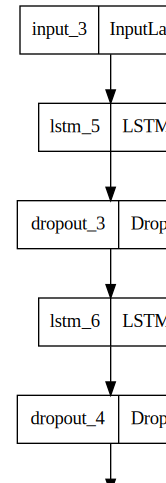

In [53]:
#------------用于绘制模型细节，可选--------------#
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model

%matplotlib inline
plot_model(model, to_file='shakespeare.png')
SVG(model_to_dot(model).create(prog='dot', format='svg'))
#------------------------------------------------#

RNN莎士比亚模型与你为恐龙名字建立的模型非常相似。唯一的主要区别是：
- LSTM代替基本的RNN捕获更长的距离依赖关系
- 该模型是一个更深层的LSTM模型（2层）
- 使用keras而不是Python来简化代码